## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import os
import random

import numpy as np
import pandas as pd
from celluloid import Camera
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm

from dataloader import loader
from evaluator import compute_threshold, evaluate

# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2023-02-21 23:58:33.464429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

In [2]:
df_train, df_test, df_test_label = loader(dataset="SMAP")

## Prepare training data


In [3]:
# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
df_test_value = pd.DataFrame(scaler.transform(df_test))
print("Number of training samples:", len(df_training_value))
print("Number of training samples:", len(df_test_value))

Number of training samples: 135183
Number of training samples: 427617


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [4]:
TIME_STEPS = 100


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Training input shape:  (135084, 100, 25)
Test input shape:  (427518, 100, 25)


## Build a model

In [5]:
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.RepeatVector(x_train.shape[1]),
        layers.LSTM(32, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(x_train.shape[1] * x_train.shape[2]),
        layers.Reshape([x_train.shape[1], x_train.shape[2]]),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

2023-02-21 23:58:38.672099: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-21 23:58:38.715889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1e:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-21 23:58:38.716250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-21 23:58:38.716581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:20:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 8

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           23040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 2500)              162500    
_________________________________________________________________
reshape (Reshape)            (None, 100, 25)           0

## Train the model


In [6]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

2023-02-21 23:58:46.151660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-21 23:58:46.171941: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/50


2023-02-21 23:58:49.338189: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-21 23:58:50.168336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-02-21 23:58:50.406966: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-21 23:58:51.123371: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-21 23:58:51.123438: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


845/845 [==============================] - 32s 31ms/step - loss: 0.9951 - val_loss: 0.4072
Epoch 2/50
845/845 [==============================] - 25s 30ms/step - loss: 0.9430 - val_loss: 0.3863
Epoch 3/50
845/845 [==============================] - 25s 29ms/step - loss: 0.9203 - val_loss: 0.3777
Epoch 4/50
845/845 [==============================] - 25s 30ms/step - loss: 0.9076 - val_loss: 0.3719
Epoch 5/50
845/845 [==============================] - 25s 29ms/step - loss: 0.8988 - val_loss: 0.3697
Epoch 6/50
845/845 [==============================] - 25s 30ms/step - loss: 0.8917 - val_loss: 0.3662
Epoch 7/50
845/845 [==============================] - 25s 29ms/step - loss: 0.8860 - val_loss: 0.3623
Epoch 8/50
845/845 [==============================] - 25s 29ms/step - loss: 0.8816 - val_loss: 0.3621
Epoch 9/50
845/845 [==============================] - 25s 29ms/step - loss: 0.8776 - val_loss: 0.3579
Epoch 10/50
845/845 [==============================] - 25s 29ms/step - loss: 0.8747 - val_los

Let's plot training and validation loss to see how the training went.

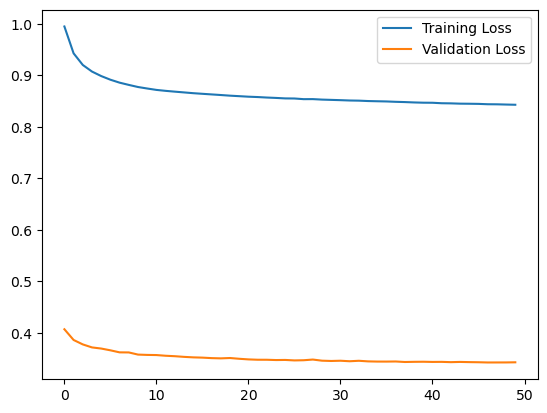

In [7]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies
### We could set threshold my using train loss, and detect which points are anomalies

In [8]:
# Get prediction of train data
x_train_pred = model.predict(x_train)
print("Predict train data done")

# Get test MAE loss.
x_test_pred = model.predict(x_test)
print("Predict test data done")

Predict train data done


2023-02-22 00:20:04.524730: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4275180000 exceeds 10% of free system memory.
2023-02-22 00:22:17.715095: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4275180000 exceeds 10% of free system memory.


Predict test data done


In [9]:
thresholds = {
    "abs_mean": compute_threshold(x_train, x_train_pred, option="abs_mean"),
    "abs_median": compute_threshold(x_train, x_train_pred, option="abs_median"),
    "abs_max": compute_threshold(x_train, x_train_pred, option="abs_max"),
    "square_mean": compute_threshold(x_train, x_train_pred, option="square_mean"),
    "square_median": compute_threshold(x_train, x_train_pred, option="square_median"),
    "rank": compute_threshold(x_train, x_train_pred, option="rank", label=df_test_label["label"]),
}
print(f'abs mean threshold: {thresholds["abs_mean"]:.3f}')
print(f'abs median threshold: {thresholds["abs_median"]:.3f}')
print(f'abs median threshold: {thresholds["abs_max"]:.3f}')
print(f'square mean threshold: {thresholds["square_mean"]:.3f}')
print(f'square median threshold: {thresholds["square_median"]:.3f}')
print(f'rank threshold: {thresholds["rank"]:.3f}')

# Detect all the samples which are anomalies.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

abs mean threshold: 3.890
abs median threshold: 3.535
abs median threshold: 42.318
square mean threshold: 18.584
square median threshold: 4.545
rank threshold: 4.321


threshold: 4.321


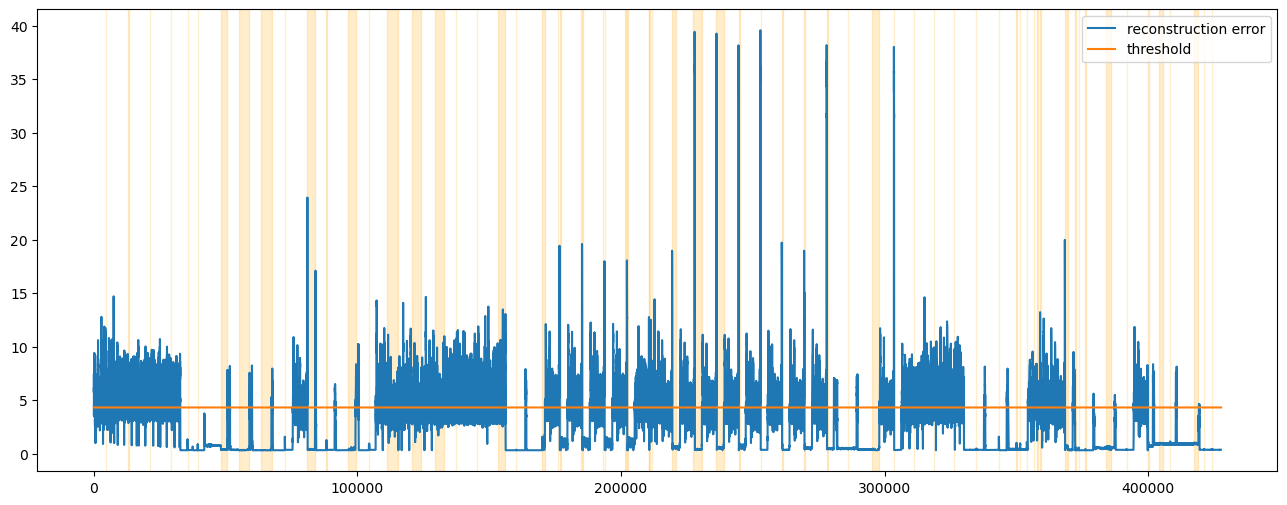

In [10]:
# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = thresholds["rank"]
print(f"threshold: {threshold:.3f}")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label["label"].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold] * len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label == True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")

## Predict & Evaluation


## #1 if any included time step has anomalies => abnormal

In [11]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["square_median"]
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

test_pred = np.zeros(len(df_test))
test_label = df_test_label["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  115369
Number of anomalous samples:  191290
accuracy: 49.73%
precision: 8.11%
recall: 28.35%
f1: 12.61%


## #2 If half of included time steps has anomaly => abnormal

In [12]:
# data i is an anomaly if ratio of anomalies sequences/involved total sequences >= 0.5
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["square_median"]
test_anomalies = np.zeros(len(df_test))
test_seqs = np.zeros(len(df_test))
test_label = df_test_label["label"]
print("Number of anomaly samples: ", np.sum(anomalies))

for idx, anomaly in enumerate(anomalies):
    test_seqs[idx : min(idx + TIME_STEPS, len(df_test))] += 1
    if anomaly:
        test_anomalies[idx : min(idx + TIME_STEPS, len(df_test))] += 1
test_pred_ratio = np.divide(test_anomalies, test_seqs)
test_pred = test_pred_ratio >= 0.5
print("Number of anomalous samples: ", sum(test_pred))


accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  115369
Number of anomalous samples:  116938
accuracy: 64.40%
precision: 8.29%
recall: 17.73%
f1: 11.30%


In [13]:
idx = 4690
evaluation_array = [(test_seqs - test_anomalies)[idx:idx+400],
                    test_anomalies[idx:idx+400],
                    test_seqs[idx:idx+400],
                    test_pred_ratio[idx:idx+400],
                    test_pred[idx:idx+400],
                    df_test_label["label"][idx:idx+400]]

df = pd.DataFrame(evaluation_array, dtype=float)
df.index = ['Normal', 'Anomaly', '#Seq', 'Pred(%)', 'Pred', 'GT']
df.style.background_gradient(cmap='summer', axis=1)

### #3 we could find the threshold with highest f1 score by calculating all cases 


In [14]:
from evaluator import evaluate

label = create_sequences(df_test_label["label"], TIME_STEPS)
print(label.shape)
scores = evaluate(x_test, x_test_pred, label, n=10, scoring="abs_mean")

(427518, 100)


In [15]:
# print("f1:",np.max(scores['f1']))
idx = np.argmax(scores["f1"])

print(f"threshold: {scores['thresholds'][idx]}")
print(f"precision: {scores['precision'][idx]*100:.2f}%")
print(f"recall: {scores['recall'][idx]*100:.2f}%")
print(f"f1: {scores['f1'][idx]*100:.2f}%")

threshold: 0.0
precision: 14.35%
recall: 100.00%
f1: 25.09%
